In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import gc

# from sklearn import svm, decomposition
from preprocess import remove_high_freq, whitening, from_cifar_to_np, from_submit_to_np
from plot import imshow
from util import trainNN, cal_accuracy, cal_class_accuracy, get_submit_result, export_to_file, print_accracy
from models import *

use_pca = False
use_forieum = False
export_csv = True
csv_name = 'res5.csv'
BATCH_SIZE = 32

In [3]:
print('==> Preparing data..')
transform_train = transforms.Compose(
    [
         # transforms.RandomCrop(32, padding=4),
         transforms.RandomResizedCrop(32),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(15),
         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
         transforms.RandomResizedCrop(32),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(15),
         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) 

transform_test = transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) 


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
submitset = np.load("./test/y_test.npy")

submit_images = [ transform_test(img) for img in submitset]

submitloader = torch.utils.data.DataLoader(submit_images, batch_size=2,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainX, trainY = from_cifar_to_np(trainloader)
if not use_forieum:
    trainX = np.reshape(trainX, (50000, 3072))
print(trainX.shape)
print(trainY.shape)

(50000, 3072)
(50000,)


In [5]:
testX, testY = from_cifar_to_np(testloader)
if not use_forieum:
    testX = np.reshape(testX, (10000, 3072))
print(testX.shape)
print(testY.shape)

(10000, 3072)
(10000,)


In [6]:
submitX = from_submit_to_np(submitloader)
if not use_forieum:
    submitX = np.reshape(submitX, (12000, 3072))
print(submitX.shape)

(12000, 3072)


In [7]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


torch.Size([32, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  dog horse  deer  ship  bird plane  frog  ship


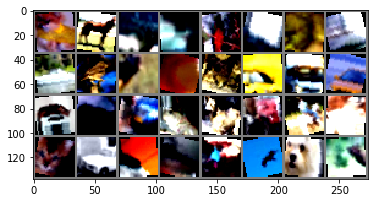

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print(images)
print(images.size())

# show images in a batch, which contains 8 images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [9]:
print('==> Building model..')
# net = SeventySevenNet()
# net = ResNet18()
net = LargeNet()
net = net.to(device)
criterion = nn.CrossEntropyLoss()

==> Building model..


In [10]:
for i in range(2): 
    optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.001)
    trainNN(net, trainloader, optimizer, criterion,  4)

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   400] loss: 0.4015093
[1,   800] loss: 0.3727735
[1,  1200] loss: 0.3560347
[2,   400] loss: 0.3359558
[2,   800] loss: 0.3251524
[2,  1200] loss: 0.3154519
[3,   400] loss: 0.3058368
[3,   800] loss: 0.2980475
[3,  1200] loss: 0.2934407
[4,   400] loss: 0.2836122
[4,   800] loss: 0.2755576
[4,  1200] loss: 0.2750167
Accuracy of the network on the 10000 test images: 62.930000 %
Accuracy of the network on the train images: 52.114000 %
Training starts
[1,   400] loss: 0.2646444
[1,   800] loss: 0.2572167
[1,  1200] loss: 0.2611012
[2,   400] loss: 0.2490948
[2,   800] loss: 0.2498436
[2,  1200] loss: 0.2513097
[3,   400] loss: 0.2451766
[3,   800] loss: 0.2417980
[3,  1200] loss: 0.2445202
[4,   400] loss: 0.2415350
[4,   800] loss: 0.2354577
[4,  1200] loss: 0.2359899
Accuracy of the network on the 10000 test images: 68.950000 %
Accuracy of the network on the train images: 59.338000 %


In [19]:
for i in range(2): 
    optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.001)
    trainNN(net, trainloader, optimizer, criterion,  4)

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   400] loss: 0.2354527
[1,   800] loss: 0.2360604
[1,  1200] loss: 0.2332695
[2,   400] loss: 0.2321029
[2,   800] loss: 0.2327034
[2,  1200] loss: 0.2289080
[3,   400] loss: 0.2286442
[3,   800] loss: 0.2291709
[3,  1200] loss: 0.2276823
[4,   400] loss: 0.2259670
[4,   800] loss: 0.2249502
[4,  1200] loss: 0.2232701
Accuracy of the network on the 10000 test images: 71.910000 %
Accuracy of the network on the train images: 61.764000 %
Training starts
[1,   400] loss: 0.2231342
[1,   800] loss: 0.2223917
[1,  1200] loss: 0.2210010
[2,   400] loss: 0.2177404
[2,   800] loss: 0.2211682
[2,  1200] loss: 0.2203266
[3,   400] loss: 0.2198522
[3,   800] loss: 0.2217299
[3,  1200] loss: 0.2191436
[4,   400] loss: 0.2205959
[4,   800] loss: 0.2184082
[4,  1200] loss: 0.2166858
Accuracy of the network on the 10000 test images: 73.190000 %
Accuracy of the network on the train images: 62.552000 %


In [20]:
for i in range(2): 
    optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.001)
    trainNN(net, trainloader, optimizer, criterion,  4)

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   400] loss: 0.1996592
[1,   800] loss: 0.1965000
[1,  1200] loss: 0.1937793
[2,   400] loss: 0.1880323
[2,   800] loss: 0.1893421
[2,  1200] loss: 0.1858385
[3,   400] loss: 0.1839727
[3,   800] loss: 0.1862823
[3,  1200] loss: 0.1850133
[4,   400] loss: 0.1827334
[4,   800] loss: 0.1831179
[4,  1200] loss: 0.1814321
Accuracy of the network on the 10000 test images: 78.140000 %
Accuracy of the network on the train images: 68.440000 %
Training starts
[1,   400] loss: 0.1781337
[1,   800] loss: 0.1821144
[1,  1200] loss: 0.1808188
[2,   400] loss: 0.1825288
[2,   800] loss: 0.1823039
[2,  1200] loss: 0.1774051
[3,   400] loss: 0.1802475
[3,   800] loss: 0.1759288
[3,  1200] loss: 0.1804802
[4,   400] loss: 0.1781666
[4,   800] loss: 0.1766026
[4,  1200] loss: 0.1774480
Accuracy of the network on the 10000 test images: 79.350000 %
Accuracy of the network on the train images: 69.492000 %


In [ ]:
for i in range(2): 
    optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=0.001)
    trainNN(net, trainloader, optimizer, criterion,  4)

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

In [21]:
params = list(net.parameters())
print(len(params))

50


In [22]:
cal_class_accuracy(net, testloader)

Accuracy of plane : 82 %
Accuracy of   car : 93 %
Accuracy of  bird : 59 %
Accuracy of   cat : 58 %
Accuracy of  deer : 78 %
Accuracy of   dog : 68 %
Accuracy of  frog : 81 %
Accuracy of horse : 83 %
Accuracy of  ship : 85 %
Accuracy of truck : 90 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


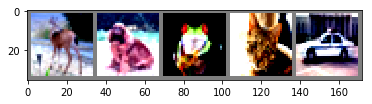

In [23]:
images = submit_images[2100:2105]
imshow(torchvision.utils.make_grid(images))

(2, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


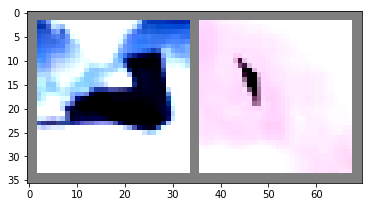

In [24]:
dataiter = iter(submitloader)
images = dataiter.next()
print(np.array(images).shape)
imshow(torchvision.utils.make_grid(images))

In [25]:
gc.collect()

2359

In [26]:
# res_labels = get_submit_result(net, submitloader)
res_per = []
with torch.no_grad():
    for i, data in enumerate(submitloader, 0):
        inputs = data.to(device)
        # forward + backward + optimize
        outputs = net(inputs)
        for o in outputs:
            res_per.append(o)
res_labels = [int(torch.max(t,0)[1]) for t in res_per]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse   dog  frog   cat   car   car   dog  frog  ship horse  deer  ship   cat  bird   car   cat plane   cat  bird horse


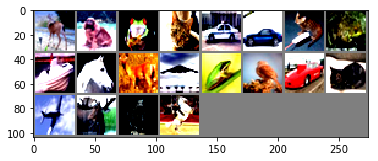

In [27]:
images = submit_images[2100:2120]
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[res_labels[j]] for j in range(2100,2120)))

In [28]:
if export_csv:
    export_to_file(csv_name, res_labels)